In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [7]:
df = pd.read_csv('playbyplaydataraw.csv')

In [8]:
print(print(df.columns))
print(df.shape)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
FIGSIZE = (14, 6)

Index(['gameId', 'actionNumber', 'clock', 'period', 'teamId', 'teamTricode',
       'personId', 'playerName', 'playerNameI', 'xLegacy', 'yLegacy',
       'shotDistance', 'shotResult', 'isFieldGoal', 'scoreHome', 'scoreAway',
       'pointsTotal', 'location', 'description', 'actionType', 'subType',
       'videoAvailable', 'shotValue', 'actionId', 'SEASON'],
      dtype='object')
None
(1697676, 25)


         events  unique_games
SEASON                       
2022-23  600925          1224
2023-24  557106          1144
2024-25  539645          1095


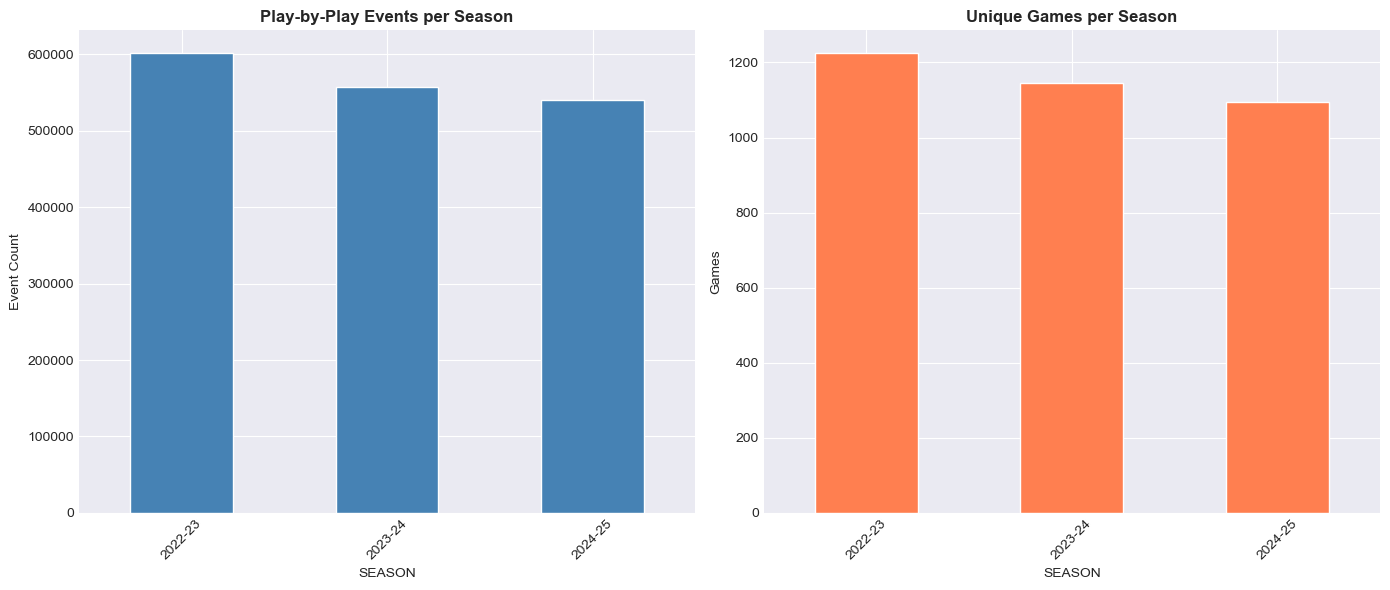

In [9]:
# We want to ensure our data isn't too disproportionate/unbalanced across seasons
season_counts = df['SEASON'].value_counts().sort_index()
games_per_season = df.groupby('SEASON')['gameId'].nunique()
print(pd.DataFrame({'events': season_counts, 'unique_games': games_per_season}))

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
season_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Play-by-Play Events per Season', fontweight='bold')
axes[0].set_ylabel('Event Count')
axes[0].tick_params(axis='x', rotation=45)

games_per_season.plot(kind='bar', ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Unique Games per Season', fontweight='bold')
axes[1].set_ylabel('Games')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Total field goal attempts: 750,737
Overall FG%: 0.387


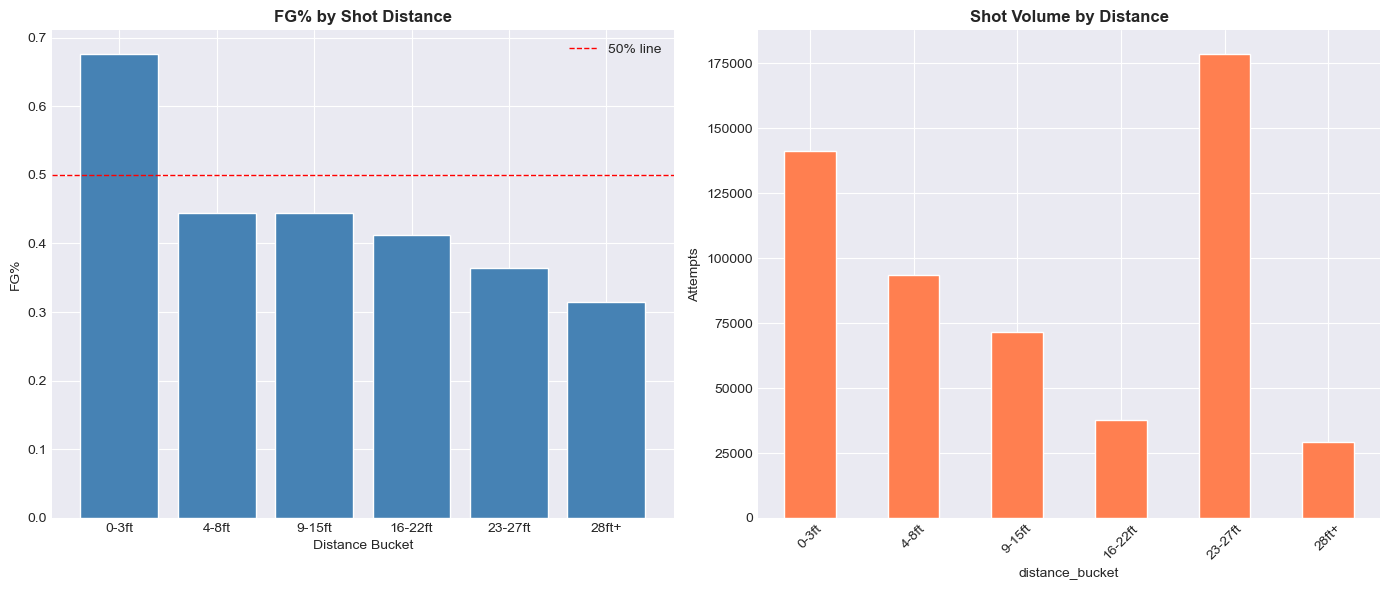

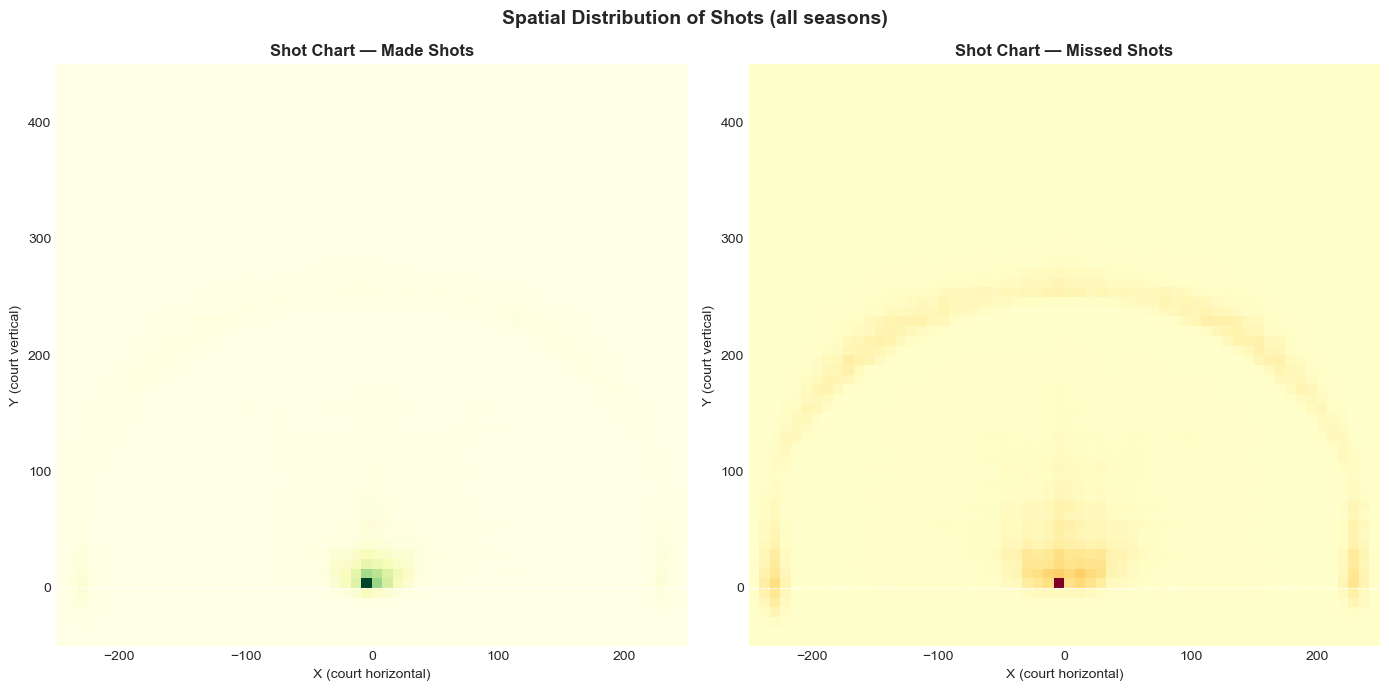


Top shot sub-types by volume:
subType
Jump Shot                         178597
Pullup Jump shot                   73975
Driving Layup Shot                 54211
Unknown                            38800
Regular                            37358
Driving Floating Jump Shot         33401
Step Back Jump shot                31675
Running Layup Shot                 20086
Normal Rebound                     16832
Driving Finger Roll Layup Shot     16510
Name: count, dtype: int64


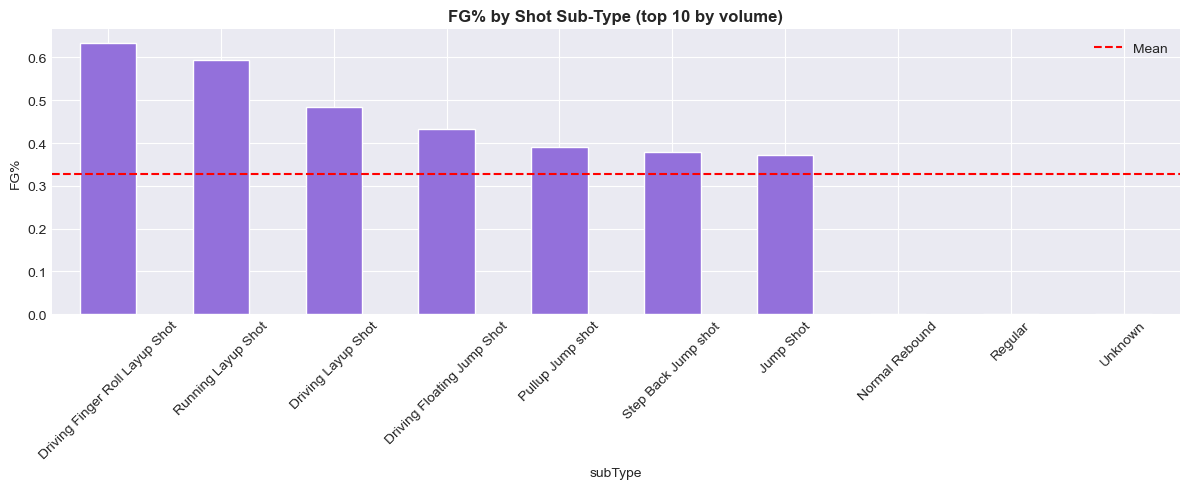

In [10]:
# Shot analysis: shots can have an effect on a team's performance, depending on what type
# of shots players take, their field goal percentage (proportion of shot attempts that go in),
# and how far they take their shots and the number of points they're worth.
shots = df[df['isFieldGoal'] == 1 & (df['teamId'] != 0)].copy()
print(f"Total field goal attempts: {len(shots):,}")
print(f"Overall FG%: {(shots['shotResult'] == 'Made').mean():.3f}")

# FG% by shot distance
shots['distance_bucket'] = pd.cut(shots['shotDistance'],
    bins=[0, 3, 8, 15, 22, 27, 80],
    labels=['0-3ft', '4-8ft', '9-15ft', '16-22ft', '23-27ft', '28ft+'])

fg_by_dist = shots.groupby('distance_bucket', observed=True).apply(
    lambda x: (x['shotResult'] == 'Made').mean(), include_groups=False).reset_index()
fg_by_dist.columns = ['distance_bucket', 'fg_pct']

vol_by_dist = shots['distance_bucket'].value_counts().sort_index()

# Shot volume by distance
# The closest 3-point shot occurs at the corners at 22ft,
# hence a large spike in the bin [22, 27) because these shots redeem
# higher point values they are more "worth it" to take.
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
axes[0].bar(fg_by_dist['distance_bucket'].astype(str), fg_by_dist['fg_pct'],
            color='steelblue', edgecolor='white')
axes[0].axhline(0.5, color='red', linestyle='--', linewidth=1, label='50% line')
axes[0].set_title('FG% by Shot Distance', fontweight='bold')
axes[0].set_ylabel('FG%')
axes[0].set_xlabel('Distance Bucket')
axes[0].legend()

vol_by_dist.plot(kind='bar', ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Shot Volume by Distance', fontweight='bold')
axes[1].set_ylabel('Attempts')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Heatmaps of shots that made vs missed
# As you can see, a lot of the missed shots were attempted at the 3-point line
made_shots = shots[shots['shotResult'] == 'Made']
missed_shots = shots[shots['shotResult'] == 'Missed']

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, subset, label, cmap in zip(
    axes,
    [made_shots, missed_shots],
    ['Made Shots', 'Missed Shots'],
    ['YlGn', 'YlOrRd']
):
    ax.hist2d(subset['xLegacy'], subset['yLegacy'],
              bins=60, cmap=cmap, range=[[-250, 250], [-50, 450]])
    ax.set_title(f'Shot Chart — {label}', fontweight='bold')
    ax.set_xlabel('X (court horizontal)')
    ax.set_ylabel('Y (court vertical)')
    ax.axhline(0, color='white', linewidth=0.8, linestyle='--')
plt.suptitle('Spatial Distribution of Shots (all seasons)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# FG% by shot sub-type
print("\nTop shot sub-types by volume:")
top_subtypes = shots['subType'].value_counts().head(10)
print(top_subtypes)

fg_by_subtype = shots[shots['subType'].isin(top_subtypes.index)].groupby('subType').apply(
    lambda x: (x['shotResult'] == 'Made').mean(), include_groups=False).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
fg_by_subtype.plot(kind='bar', ax=ax, color='mediumpurple', edgecolor='white')
ax.set_title('FG% by Shot Sub-Type (top 10 by volume)', fontweight='bold')
ax.set_ylabel('FG%')
ax.axhline(fg_by_subtype.mean(), color='red', linestyle='--', label='Mean')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# BUILD DATASET (Pre-Q4): Q1 through Q3 only
shots = df[df['isFieldGoal'] == 1 ].copy()

shots['is_made'] = shots['shotResult'] == 'Made'
shots['points_scored'] = np.where(shots['is_made'], shots['shotValue'], 0)

ft = df[df['actionType'] == 'Free Throw'].copy()
ft['points_scored'] = np.where(ft['shotResult'] == 'Made', 1, 0)

def build_pre_q4_dataset(df, shots, ft):
    """
    All features derived from Q1-Q3 only.
    Q4 data used ONLY to define the outcome (won/lost).
    """

    # --- Points per quarter (Q1-Q4 for outcome, Q1-Q3 for features) ---
    shot_pts = shots.groupby(['gameId','teamId','period'])['points_scored'].sum().reset_index()
    ft_pts   = ft.groupby(['gameId','teamId','period'])['points_scored'].sum().reset_index()
    qtr = (shot_pts
           .merge(ft_pts, on=['gameId','teamId','period'], how='outer',
                  suffixes=('_s','_ft'))
           .fillna(0))
    qtr['total_pts'] = qtr['points_scored_s'] + qtr['points_scored_ft']
    qtr = qtr[qtr['period'].between(1, 4)].copy()

    # --- Non-scoring features: Q1-Q3 only ---
    fg_qtr = (
        shots[shots['period'].between(1, 3)]
        .groupby(['gameId','teamId','period'])
        .apply(lambda x: pd.Series({
            'fg_pct':         x['is_made'].mean(),
            'fg_attempts':    len(x),
            'three_pt_rate':  (x['shotValue'] == 3).mean(),
            'at_rim_rate':    (x['shotDistance'] <= 3).mean(),
            'mid_range_rate': ((x['shotDistance'] > 3) &
                               (x['shotDistance'] < 22)).mean(),
        }), include_groups=False)
        .reset_index()
    )

    tov_qtr = (
        df[(df['actionType'] == 'Turnover') & df['period'].between(1, 3)]
        .groupby(['gameId','teamId','period'])
        .size().reset_index(name='turnovers')
    )

    # --- Pivot points to wide (need Q1-Q4 for outcome) ---
    pts_wide = (
        qtr.pivot_table(index=['gameId','teamId'], columns='period',
                        values='total_pts', aggfunc='sum')
        .rename(columns={1:'pts_Q1',2:'pts_Q2',3:'pts_Q3',4:'pts_Q4'})
        .reset_index()
    )

    # --- Pivot non-scoring features (Q1-Q3 only) ---
    def pivot_feat(df_in, val_col, prefix):
        return (
            df_in.pivot_table(index=['gameId','teamId'], columns='period',
                              values=val_col, aggfunc='mean')
            .rename(columns={1:f'{prefix}_Q1',2:f'{prefix}_Q2',3:f'{prefix}_Q3'})
            .reset_index()
        )

    fg_wide  = pivot_feat(fg_qtr,  'fg_pct',         'fg')
    tpr_wide = pivot_feat(fg_qtr,  'three_pt_rate',  'tpr')
    rim_wide = pivot_feat(fg_qtr,  'at_rim_rate',    'rim')
    mid_wide = pivot_feat(fg_qtr,  'mid_range_rate', 'mid')
    tov_wide = pivot_feat(tov_qtr, 'turnovers',      'tov')

    gt = pts_wide
    for w in [fg_wide, tpr_wide, rim_wide, mid_wide, tov_wide]:
        gt = gt.merge(w, on=['gameId','teamId'], how='left')

    # --- Total points and winner (uses Q4 for outcome only) ---
    gt['total_pts'] = gt[['pts_Q1','pts_Q2','pts_Q3','pts_Q4']].sum(axis=1)
    winners = gt.groupby('gameId')['total_pts'].idxmax()
    gt['won'] = 0
    gt.loc[winners, 'won'] = 1

    # --- Paired game dataset: one row per game, winner vs loser ---
    w = gt[gt['won']==1].add_suffix('_w').rename(columns={'gameId_w':'gameId'})
    l = gt[gt['won']==0].add_suffix('_l').rename(columns={'gameId_l':'gameId'})
    gd = w.merge(l, on='gameId')

    # Cumulative point differential at end of Q1, Q2, Q3 (pre-Q4 only)
    gd['cum_diff_Q1'] = gd['pts_Q1_w'] - gd['pts_Q1_l']
    gd['cum_diff_Q2'] = gd['cum_diff_Q1'] + (gd['pts_Q2_w'] - gd['pts_Q2_l'])
    gd['cum_diff_Q3'] = gd['cum_diff_Q2'] + (gd['pts_Q3_w'] - gd['pts_Q3_l'])

    # Outcome: final margin (uses Q4 — only for target, not features)
    gd['final_margin'] = gd['cum_diff_Q3'] + (gd['pts_Q4_w'] - gd['pts_Q4_l'])

    # Momentum = how cum_diff MOVED during each quarter
    # Positive = winner gained ground that quarter
    # These are all pre-Q4 and knowable before Q4 starts
    gd['momentum_Q1'] = gd['cum_diff_Q1']                          # Q1 swing from 0
    gd['momentum_Q2'] = gd['cum_diff_Q2'] - gd['cum_diff_Q1']      # Q2 swing
    gd['momentum_Q3'] = gd['cum_diff_Q3'] - gd['cum_diff_Q2']      # Q3 swing — key feature

    # Non-scoring differentials (winner minus loser), Q1-Q3 only
    for q in ['Q1','Q2','Q3']:
        gd[f'fg_diff_{q}']  = gd[f'fg_{q}_w']  - gd[f'fg_{q}_l']
        gd[f'tov_diff_{q}'] = gd[f'tov_{q}_w']  - gd[f'tov_{q}_l']
        gd[f'tpr_diff_{q}'] = gd[f'tpr_{q}_w']  - gd[f'tpr_{q}_l']
        gd[f'rim_diff_{q}'] = gd[f'rim_{q}_w']  - gd[f'rim_{q}_l']
        gd[f'mid_diff_{q}'] = gd[f'mid_{q}_w']  - gd[f'mid_{q}_l']

    return gt, gd

game_team, game_diffs = build_pre_q4_dataset(df, shots, ft)
print(f"Pre-Q4 features: Q1, Q2, Q3 only")
print(f"Games in dataset: {len(game_diffs):,}")
print(f"\nAverage final margin: "
      f"{game_diffs['final_margin'].mean():.1f} pts")

Pre-Q4 features: Q1, Q2, Q3 only
Games in dataset: 3,463

Average final margin: 12.4 pts


5-Fold CV R² — cum_diff predicting final margin:
  After Q1: 0.090 ± 0.010  (n=3,463)
  After Q2: 0.228 ± 0.024  (n=3,463)
  After Q3: 0.516 ± 0.034  (n=3,463)

  Interpretation: R² rises monotonically — the score becomes
  increasingly predictive of the final outcome as quarters pass.


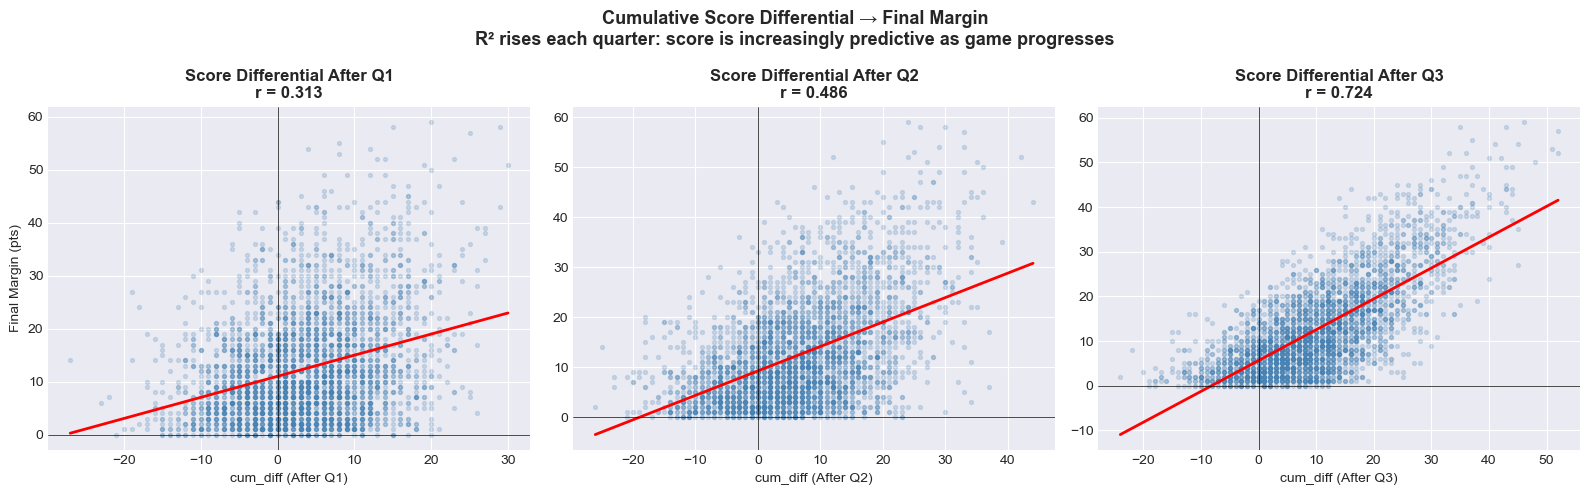

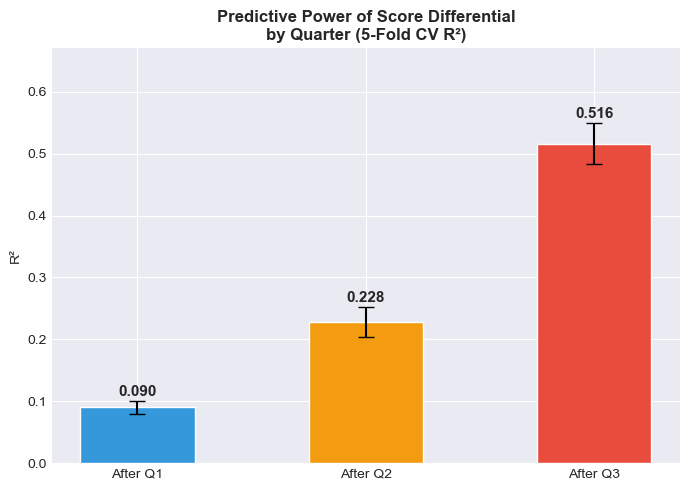

In [12]:
# ============================================================
# Does the cumulative score difference between teams predict game outcome?
#    Cumulative difference measures the point differential between the winning
#    and losing team at the end of each quarter. This feature encapsulates the
#    degree to which the winning team is winning by and all score-related features.
#    This appears to be our strongest predictor.
# ============================================================
def cv_r2(cols, df, target='final_margin', cv=5):
    clean = df[cols + [target]].dropna()
    X = StandardScaler().fit_transform(clean[cols].values)
    y = clean[target].values
    scores = cross_val_score(Ridge(), X, y, cv=cv, scoring='r2')
    return scores.mean(), scores.std(), len(clean)

# --- R² at each quarter checkpoint ---
r2_q1, sd_q1, n_q1 = cv_r2(['cum_diff_Q1'], game_diffs)
r2_q2, sd_q2, n_q2 = cv_r2(['cum_diff_Q2'], game_diffs)
r2_q3, sd_q3, n_q3 = cv_r2(['cum_diff_Q3'], game_diffs)

print("5-Fold CV R² — cum_diff predicting final margin:")
print(f"  After Q1: {r2_q1:.3f} ± {sd_q1:.3f}  (n={n_q1:,})")
print(f"  After Q2: {r2_q2:.3f} ± {sd_q2:.3f}  (n={n_q2:,})")
print(f"  After Q3: {r2_q3:.3f} ± {sd_q3:.3f}  (n={n_q3:,})")
print(f"\n  Interpretation: R² rises monotonically — the score becomes")
print(f"  increasingly predictive of the final outcome as quarters pass.")

# --- Correlations ---
r_q1, _ = stats.pearsonr(game_diffs['cum_diff_Q1'], game_diffs['final_margin'])
r_q2, _ = stats.pearsonr(game_diffs['cum_diff_Q2'], game_diffs['final_margin'])
r_q3, _ = stats.pearsonr(game_diffs['cum_diff_Q3'], game_diffs['final_margin'])

# --- Visualize ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col, r, label in zip(
    axes,
    ['cum_diff_Q1', 'cum_diff_Q2', 'cum_diff_Q3'],
    [r_q1, r_q2, r_q3],
    ['After Q1', 'After Q2', 'After Q3']
):
    clean = game_diffs[[col, 'final_margin']].dropna()
    ax.scatter(clean[col], clean['final_margin'],
               alpha=0.2, s=8, color='steelblue')
    m, b = np.polyfit(clean[col], clean['final_margin'], 1)
    x_l  = np.linspace(clean[col].min(), clean[col].max(), 100)
    ax.plot(x_l, m*x_l+b, color='red', linewidth=2)
    ax.set_title(f'Score Differential {label}\nr = {r:.3f}', fontweight='bold')
    ax.set_xlabel(f'cum_diff ({label})')
    ax.set_ylabel('Final Margin (pts)' if ax == axes[0] else '')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

plt.suptitle(
    'Cumulative Score Differential → Final Margin\n'
    'R² rises each quarter: score is increasingly predictive as game progresses',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

# --- R² bar chart across quarters ---
fig, ax = plt.subplots(figsize=(7, 5))
quarters   = ['After Q1', 'After Q2', 'After Q3']
r2_vals    = [r2_q1, r2_q2, r2_q3]
r2_sds     = [sd_q1, sd_q2, sd_q3]
bar_colors = ['#3498db', '#f39c12', '#e74c3c']

ax.bar(quarters, r2_vals, yerr=r2_sds, color=bar_colors,
       edgecolor='white', capsize=6, width=0.5)
ax.set_title('Predictive Power of Score Differential\nby Quarter (5-Fold CV R²)',
             fontweight='bold')
ax.set_ylabel('R²')
ax.set_ylim(0, max(r2_vals) * 1.3)
for i, (m, s) in enumerate(zip(r2_vals, r2_sds)):
    ax.text(i, m + s + 0.008, f'{m:.3f}', ha='center',
            fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()


Does momentum entering Q4 from Q3 help predict outcome?
momentum_Q3 = cum_diff_Q3 - cum_diff_Q2
Close games (within 8 pts at Q3): 1,567 of 3,463


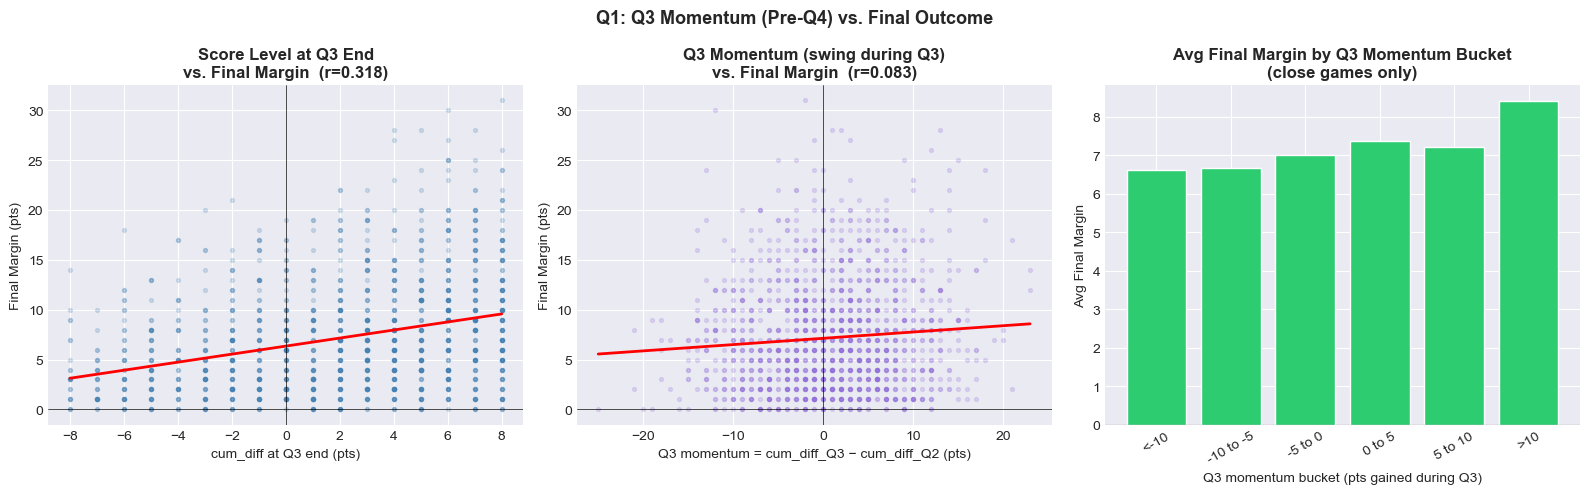


Results (close games, within 8 pts at Q3):
  cum_diff_Q3 vs final margin:            r = 0.318
  momentum_Q3 vs final margin:            r = 0.083
  momentum_Q3 vs final margin (partial,
  controlling for cum_diff_Q3):           r = 0.039, p = 0.1277


In [13]:
# ============================================================
# Does momentum entering Q4 from Q3 predict game outcome?
# Momentum: how much the winner gained/lost ground during Q3
# momentum_Q3 = cum_diff_Q3 - cum_diff_Q2
# ============================================================
print("\n" + "="*60)
print("Does momentum entering Q4 from Q3 help predict outcome?")
print("momentum_Q3 = cum_diff_Q3 - cum_diff_Q2")
print("="*60)

# Restrict to close games at Q3 to isolate momentum from blowouts
close = game_diffs[game_diffs['cum_diff_Q3'].abs() <= 8].copy()
print(f"Close games (within 8 pts at Q3): {len(close):,} of {len(game_diffs):,}")

r_level, _    = stats.pearsonr(close['cum_diff_Q3'],  close['final_margin'])
r_momentum, _ = stats.pearsonr(close['momentum_Q3'],  close['final_margin'])

# Partial correlation: momentum_Q3 with final_margin, controlling for cum_diff_Q3
from sklearn.linear_model import LinearRegression

def partial_corr(x, z, y):
    """Correlation of x with y after removing the effect of z."""
    resid_x = x - LinearRegression().fit(z.reshape(-1,1), x).predict(z.reshape(-1,1))
    resid_y = y - LinearRegression().fit(z.reshape(-1,1), y).predict(z.reshape(-1,1))
    r, p = stats.pearsonr(resid_x, resid_y)
    return r, p

r_partial, p_partial = partial_corr(
    close['momentum_Q3'].values,
    close['cum_diff_Q3'].values,
    close['final_margin'].values
)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: score level vs final margin
axes[0].scatter(close['cum_diff_Q3'], close['final_margin'],
                alpha=0.2, s=8, color='steelblue')
m, b = np.polyfit(close['cum_diff_Q3'], close['final_margin'], 1)
x_l = np.linspace(close['cum_diff_Q3'].min(), close['cum_diff_Q3'].max(), 100)
axes[0].plot(x_l, m*x_l+b, color='red', linewidth=2)
axes[0].set_title(f'Score Level at Q3 End\nvs. Final Margin  (r={r_level:.3f})',
                  fontweight='bold')
axes[0].set_xlabel('cum_diff at Q3 end (pts)')
axes[0].set_ylabel('Final Margin (pts)')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)

# Plot 2: Q3 momentum vs final margin
axes[1].scatter(close['momentum_Q3'], close['final_margin'],
                alpha=0.2, s=8, color='mediumpurple')
m, b = np.polyfit(close['momentum_Q3'], close['final_margin'], 1)
x_l = np.linspace(close['momentum_Q3'].min(), close['momentum_Q3'].max(), 100)
axes[1].plot(x_l, m*x_l+b, color='red', linewidth=2)
axes[1].set_title(f'Q3 Momentum (swing during Q3)\nvs. Final Margin  (r={r_momentum:.3f})',
                  fontweight='bold')
axes[1].set_xlabel('Q3 momentum = cum_diff_Q3 − cum_diff_Q2 (pts)')
axes[1].set_ylabel('Final Margin (pts)')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)

# Plot 3: momentum bucketed — win rate entering Q4 by Q3 swing
close['momentum_Q3_bucket'] = pd.cut(
    close['momentum_Q3'],
    bins=[-40, -10, -5, 0, 5, 10, 40],
    labels=['<-10', '-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '>10']
)
# Win rate here = % of games where winner also won Q3
q3_win_rate = close.groupby('momentum_Q3_bucket', observed=True).apply(
    lambda x: (x['momentum_Q3'] > 0).mean(), include_groups=False
).reset_index()
q3_win_rate.columns = ['bucket', 'pct_positive_momentum']

bucket_final = close.groupby('momentum_Q3_bucket', observed=True)['final_margin'].mean().reset_index()

axes[2].bar(bucket_final['momentum_Q3_bucket'].astype(str),
            bucket_final['final_margin'],
            color=['#e74c3c' if v < 0 else '#2ecc71'
                   for v in bucket_final['final_margin']],
            edgecolor='white')
axes[2].axhline(0, color='black', linewidth=0.8)
axes[2].set_title('Avg Final Margin by Q3 Momentum Bucket\n(close games only)',
                  fontweight='bold')
axes[2].set_xlabel('Q3 momentum bucket (pts gained during Q3)')
axes[2].set_ylabel('Avg Final Margin')
axes[2].tick_params(axis='x', rotation=30)

plt.suptitle('Q1: Q3 Momentum (Pre-Q4) vs. Final Outcome',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nResults (close games, within 8 pts at Q3):")
print(f"  cum_diff_Q3 vs final margin:            r = {r_level:.3f}")
print(f"  momentum_Q3 vs final margin:            r = {r_momentum:.3f}")
print(f"  momentum_Q3 vs final margin (partial,")
print(f"  controlling for cum_diff_Q3):           r = {r_partial:.3f}, p = {p_partial:.4f}")

Q1-Q3 field goal attempts: 466,019

Shots per zone:
zone
at_rim       154307
short_mid    113512
long_mid      39996
short_3       22493
deep_3       135711
Name: count, dtype: int64

Overall FG% per zone:
zone
at_rim       0.623
short_mid    0.447
long_mid     0.427
short_3      0.388
deep_3       0.358
Name: is_made, dtype: float64

Computing zone features per team per game (Q1-Q3)...
Zone feature rows: 6,926

NaN counts:
gameId              0
teamId              0
total_fga           0
rate_at_rim         0
fg_at_rim           0
rate_short_mid      0
fg_short_mid        0
rate_long_mid       0
fg_long_mid        91
rate_short_3        0
fg_short_3        352
rate_deep_3         0
fg_deep_3           0
dtype: int64

Sample:
     gameId      teamId  total_fga  rate_at_rim  fg_at_rim  rate_short_mid  fg_short_mid  rate_long_mid  fg_long_mid  rate_short_3  fg_short_3  rate_deep_3  fg_deep_3
0  22200001  1610612738         63        0.270      0.706           0.302         0.579         

/var/folders/87/dz8gfl555b91l7f8l_dz9dm00000gp/T/ipykernel_51090/1838129079.py:193: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([c.replace('diff_rate_','').replace('diff_fg_','')
/var/folders/87/dz8gfl555b91l7f8l_dz9dm00000gp/T/ipykernel_51090/1838129079.py:193: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([c.replace('diff_rate_','').replace('diff_fg_','')


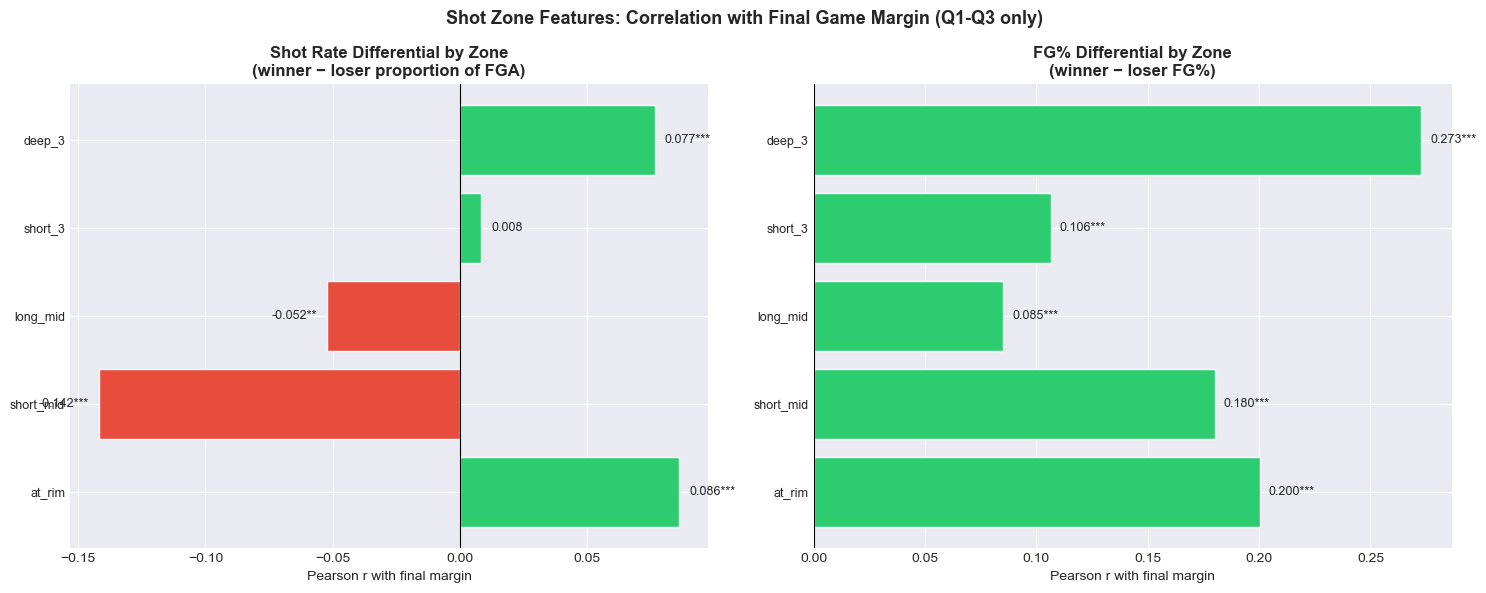


5-Fold CV R² — Zone Features vs. Baseline:
Model                                             R²      ±      ΔR²  n
------------------------------------------------------------------------
Baseline: cum_diff_Q3 only                    0.516  0.034        —  3,463
+ Shot rate by zone only                      0.517  0.034  +0.0007  3,463
+ FG% by zone only                            0.507  0.037  -0.0091  3,035
+ Both rate + FG% by zone                     0.507  0.038  -0.0090  3,035


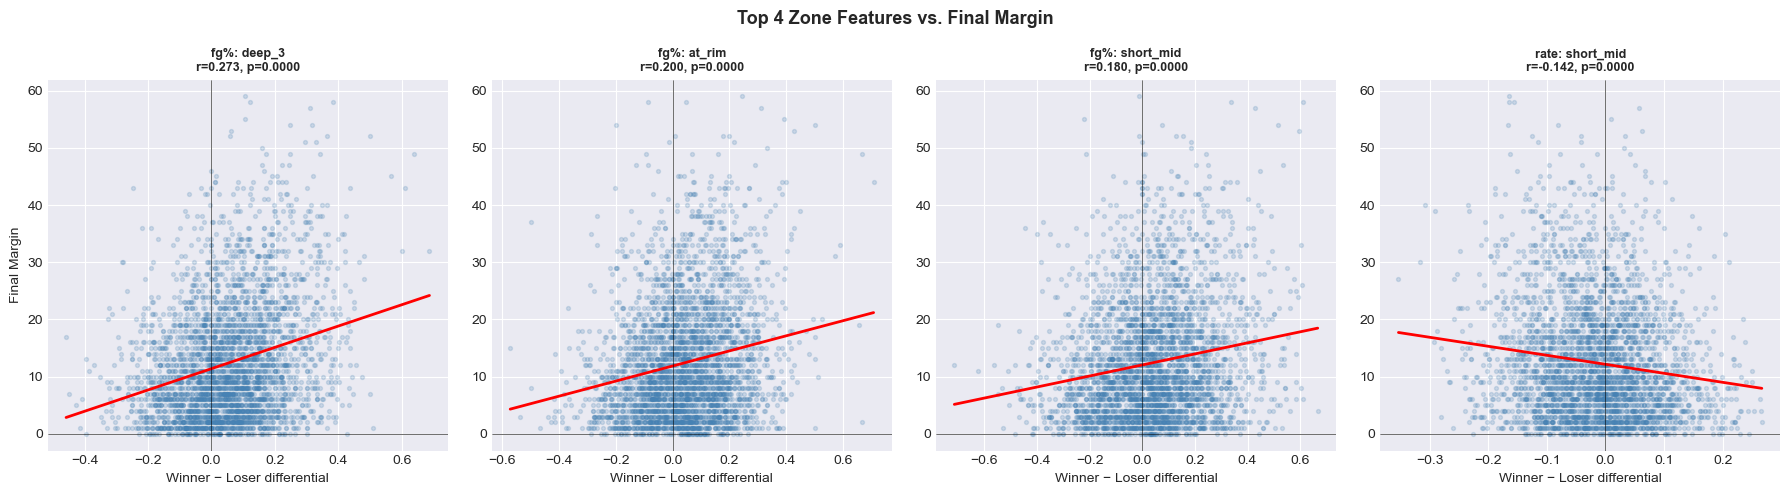


Winner vs. Loser Shot Zone Profile (Q1-Q3 avg):
           Winner Rate  Loser Rate  Winner FG%  Loser FG%  Rate Diff  FG% Diff
Zone                                                                          
at_rim           0.335       0.326       0.649      0.607      0.009     0.042
short_mid        0.235       0.251       0.461      0.423     -0.016     0.038
long_mid         0.085       0.088       0.438      0.399     -0.003     0.039
short_3          0.049       0.048       0.410      0.358      0.001     0.052
deep_3           0.296       0.287       0.383      0.328      0.009     0.055


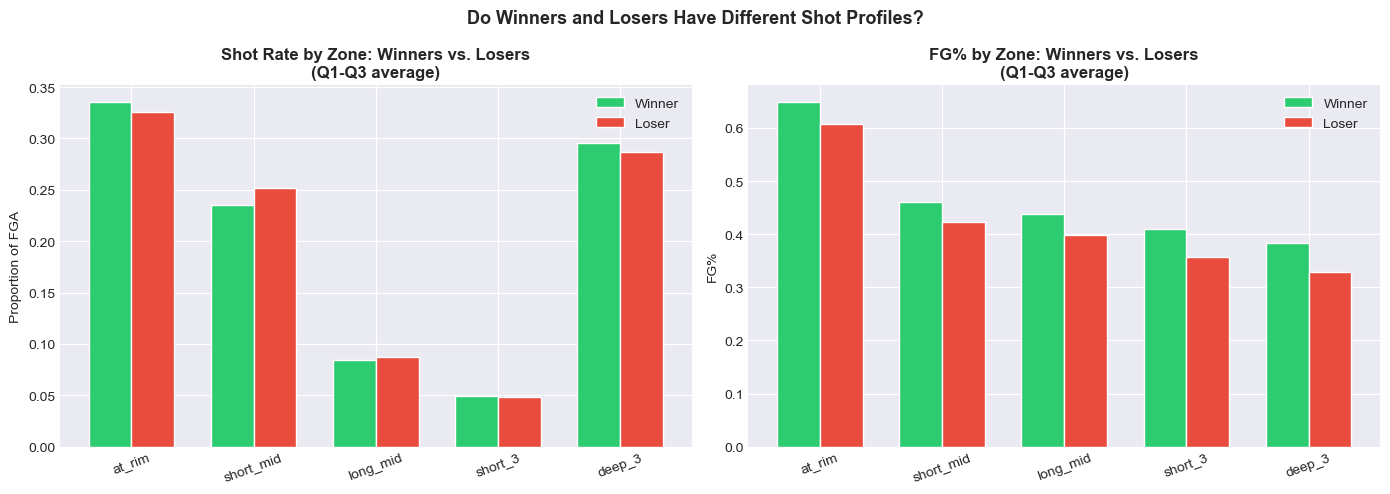

Winners and losers take shots from nearly identical zones, and the rate differentials are tiny.
Winners take 0.9% more at-rim, 1.6% fewer short mid-range, 0.9% more deep 3s


In [14]:
# ============================================================
# SHOT ZONE FEATURES: Distance proportions + FG% by zone
# Taking into account the distance of shots taken and their FG%
# Q1-Q3 only — strict pre-Q4 constraint
#
# Zones (2PT/3PT boundary at 22ft):
#   At Rim:    0-3ft   (highest efficiency)
#   Short Mid: 4-13ft  (2PT, low value)
#   Long Mid:  14-21ft (2PT, lowest value)
#   Corner/Short 3: 22-24ft
#   Deep 3:    25ft+
#
# For each zone, per (gameId, teamId, Q1-Q3):
#   - shot_rate: proportion of total FGA from that zone
#   - fg_pct:    make rate from that zone
# ============================================================
BINS   = [0,   3,  13,  21,  24, 100]
LABELS = ['at_rim', 'short_mid', 'long_mid', 'short_3', 'deep_3']

shots = df[
    (df['isFieldGoal'] == 1) &
    (df['period'].between(1, 3)) &
    (df['teamId'] != 0)
].copy()
shots['is_made'] = shots['shotResult'] == 'Made'

shots['zone'] = pd.cut(
    shots['shotDistance'],
    bins=BINS,
    labels=LABELS,
    include_lowest=True
)

print(f"Q1-Q3 field goal attempts: {len(shots):,}")
print("\nShots per zone:")
print(shots['zone'].value_counts().reindex(LABELS))
print("\nOverall FG% per zone:")
print(shots.groupby('zone', observed=True)['is_made'].mean().reindex(LABELS).round(3))


# ============================================================
# STEP 1: Compute per-(gameId, teamId) zone features
# ============================================================

def compute_zone_features(shots, labels):
    """
    For each (gameId, teamId), compute:
      - shot_rate_{zone}: % of FGA from that zone
      - fg_pct_{zone}:   FG% from that zone (NaN if 0 attempts)
    """
    results = []

    for (gid, tid), grp in shots.groupby(['gameId', 'teamId']):
        total_fga = len(grp)
        row = {'gameId': gid, 'teamId': tid, 'total_fga': total_fga}

        for zone in labels:
            zone_grp = grp[grp['zone'] == zone]
            n = len(zone_grp)
            row[f'rate_{zone}'] = n / total_fga if total_fga > 0 else np.nan
            row[f'fg_{zone}']   = zone_grp['is_made'].mean() if n > 0 else np.nan

        results.append(row)

    return pd.DataFrame(results)

print("\nComputing zone features per team per game (Q1-Q3)...")
zone_df = compute_zone_features(shots, LABELS)
print(f"Zone feature rows: {len(zone_df):,}")
print("\nNaN counts:")
print(zone_df.isnull().sum())
print("\nSample:")
print(zone_df.head(4).round(3).to_string())


# ============================================================
# STEP 2: Build paired (winner vs loser) game dataset
# ============================================================

# Rebuild points + outcome
all_shots = df[df['isFieldGoal'] == 1].copy()
all_shots['points_scored'] = np.where(
    all_shots['shotResult'] == 'Made', all_shots['shotValue'], 0
)
ft_df = df[df['actionType'] == 'Free Throw'].copy()
ft_df['points_scored'] = np.where(ft_df['shotResult'] == 'Made', 1, 0)

shot_pts = all_shots.groupby(['gameId','teamId','period'])['points_scored'].sum().reset_index()
ft_pts   = ft_df.groupby(['gameId','teamId','period'])['points_scored'].sum().reset_index()

qtr = (shot_pts
       .merge(ft_pts, on=['gameId','teamId','period'], how='outer',
              suffixes=('_s','_ft'))
       .fillna(0))
qtr['total_pts'] = qtr['points_scored_s'] + qtr['points_scored_ft']
qtr = qtr[qtr['period'].between(1,4) & (qtr['teamId'] != 0)].copy()

pts_wide = (
    qtr.pivot_table(index=['gameId','teamId'], columns='period',
                    values='total_pts', aggfunc='sum')
    .rename(columns={1:'pts_Q1',2:'pts_Q2',3:'pts_Q3',4:'pts_Q4'})
    .reset_index()
)
pts_wide['total_pts'] = pts_wide[['pts_Q1','pts_Q2','pts_Q3','pts_Q4']].sum(axis=1)
winners = pts_wide.groupby('gameId')['total_pts'].idxmax()
pts_wide['won'] = 0
pts_wide.loc[winners, 'won'] = 1

# Merge zone features
game_level = pts_wide.merge(zone_df, on=['gameId','teamId'], how='left')

# Pair winner vs loser
w = game_level[game_level['won']==1].add_suffix('_w').rename(columns={'gameId_w':'gameId'})
l = game_level[game_level['won']==0].add_suffix('_l').rename(columns={'gameId_l':'gameId'})
gd = w.merge(l, on='gameId')

# Cumulative score differentials
gd['cum_diff_Q1']  = gd['pts_Q1_w'] - gd['pts_Q1_l']
gd['cum_diff_Q2']  = gd['cum_diff_Q1'] + (gd['pts_Q2_w'] - gd['pts_Q2_l'])
gd['cum_diff_Q3']  = gd['cum_diff_Q2'] + (gd['pts_Q3_w'] - gd['pts_Q3_l'])
gd['final_margin'] = gd['cum_diff_Q3'] + (gd['pts_Q4_w'] - gd['pts_Q4_l'])

# Zone differentials: winner - loser
zone_rate_cols = [f'rate_{z}' for z in LABELS]
zone_fg_cols   = [f'fg_{z}'   for z in LABELS]
all_zone_cols  = zone_rate_cols + zone_fg_cols

diff_cols = []
for f in all_zone_cols:
    col = f'diff_{f}'
    gd[col] = gd[f'{f}_w'] - gd[f'{f}_l']
    diff_cols.append(col)

diff_rate_cols = [f'diff_rate_{z}' for z in LABELS]
diff_fg_cols   = [f'diff_fg_{z}'   for z in LABELS]

print(f"\nPaired dataset: {len(gd):,} games")
print("\nNaN counts in zone differentials:")
print(gd[diff_cols].isnull().sum())


# ============================================================
# STEP 3: Correlation with final margin
# ============================================================

corr_results = []
for col in diff_cols:
    clean = gd[[col, 'final_margin']].dropna()
    if len(clean) < 50:
        continue
    r, p = stats.pearsonr(clean[col], clean['final_margin'])
    feature_type = 'Shot Rate' if 'rate' in col else 'FG%'
    zone = col.replace('diff_rate_','').replace('diff_fg_','')
    corr_results.append({
        'feature': col, 'zone': zone,
        'type': feature_type, 'r': r, 'p': p, 'n': len(clean)
    })

corr_df = pd.DataFrame(corr_results).sort_values('r', key=abs, ascending=False)
print("\nCorrelation with final margin (sorted by |r|):")
print(corr_df[['feature','r','p','n']].to_string(index=False))


# ============================================================
# STEP 4: Visualize correlations — rate vs FG% side by side
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for ax, feat_type, cols, title in zip(
    axes,
    ['Shot Rate', 'FG%'],
    [diff_rate_cols, diff_fg_cols],
    ['Shot Rate Differential by Zone\n(winner − loser proportion of FGA)',
     'FG% Differential by Zone\n(winner − loser FG%)']
):
    sub = corr_df[corr_df['type'] == feat_type].set_index('feature').reindex(cols)
    colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in sub['r']]
    ax.barh(sub.index, sub['r'], color=colors, edgecolor='white')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Pearson r with final margin')

    for i, (idx, row) in enumerate(sub.iterrows()):
        if pd.isna(row['r']):
            continue
        sig = '***' if row['p'] < 0.001 else '**' if row['p'] < 0.01 else '*' if row['p'] < 0.05 else ''
        offset = 0.004 if row['r'] >= 0 else -0.004
        ax.text(row['r'] + offset, i, f"{row['r']:.3f}{sig}",
                va='center', ha='left' if row['r'] >= 0 else 'right', fontsize=9)

    # Clean up y-tick labels
    ax.set_yticklabels([c.replace('diff_rate_','').replace('diff_fg_','')
                        for c in cols], fontsize=9)

plt.suptitle('Shot Zone Features: Correlation with Final Game Margin (Q1-Q3 only)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


# ============================================================
# STEP 5: Incremental R² test
# ============================================================

def cv_r2(cols, df, target='final_margin', cv=5):
    clean = df[cols + [target]].dropna()
    X = StandardScaler().fit_transform(clean[cols].values)
    y = clean[target].values
    scores = cross_val_score(Ridge(), X, y, cv=cv, scoring='r2')
    return scores.mean(), scores.std(), len(clean)

r2_base, sd_base, n_base = cv_r2(['cum_diff_Q3'], gd)

valid_rate = [c for c in diff_rate_cols if gd[c].notna().sum() > 100]
valid_fg   = [c for c in diff_fg_cols   if gd[c].notna().sum() > 100]
valid_all  = valid_rate + valid_fg

groups = {
    'Shot rate by zone only':     valid_rate,
    'FG% by zone only':           valid_fg,
    'Both rate + FG% by zone':    valid_all,
}

print(f"\n5-Fold CV R² — Zone Features vs. Baseline:")
print(f"{'Model':<45} {'R²':>6}  {'±':>5}  {'ΔR²':>7}  n")
print("-" * 72)
print(f"{'Baseline: cum_diff_Q3 only':<45} {r2_base:.3f}  {sd_base:.3f}  {'—':>7}  {n_base:,}")

group_results = []
for label, cols in groups.items():
    r2, sd, n = cv_r2(['cum_diff_Q3'] + cols, gd)
    delta = r2 - r2_base
    print(f"{'+ ' + label:<45} {r2:.3f}  {sd:.3f}  {delta:+.4f}  {n:,}")
    group_results.append({'label': label, 'r2': r2, 'sd': sd, 'delta': delta})


# ============================================================
# STEP 6: Scatter plots — top 4 correlating zone features
# ============================================================

top4 = corr_df.dropna(subset=['r']).head(4)['feature'].tolist()

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for ax, feat in zip(axes, top4):
    clean = gd[[feat, 'final_margin']].dropna()
    r, p  = stats.pearsonr(clean[feat], clean['final_margin'])
    ax.scatter(clean[feat], clean['final_margin'],
               alpha=0.2, s=8, color='steelblue')
    m, b = np.polyfit(clean[feat], clean['final_margin'], 1)
    x_l  = np.linspace(clean[feat].min(), clean[feat].max(), 100)
    ax.plot(x_l, m*x_l+b, color='red', linewidth=2)
    label = feat.replace('diff_rate_','rate: ').replace('diff_fg_','fg%: ')
    ax.set_title(f'{label}\nr={r:.3f}, p={p:.4f}', fontweight='bold', fontsize=9)
    ax.set_xlabel('Winner − Loser differential')
    ax.set_ylabel('Final Margin' if ax == axes[0] else '')
    ax.axhline(0, color='black', linewidth=0.4)
    ax.axvline(0, color='black', linewidth=0.4)

plt.suptitle('Top 4 Zone Features vs. Final Margin', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


# ============================================================
# STEP 7: Heatmap — winner vs loser shot zone profiles
# ============================================================

winner_profile = gd[[f'rate_{z}_w' for z in LABELS]].mean()
loser_profile  = gd[[f'rate_{z}_l' for z in LABELS]].mean()
winner_fg      = gd[[f'fg_{z}_w'   for z in LABELS]].mean()
loser_fg       = gd[[f'fg_{z}_l'   for z in LABELS]].mean()

profile_df = pd.DataFrame({
    'Zone':        LABELS,
    'Winner Rate': winner_profile.values,
    'Loser Rate':  loser_profile.values,
    'Winner FG%':  winner_fg.values,
    'Loser FG%':   loser_fg.values,
}).set_index('Zone')
profile_df['Rate Diff'] = profile_df['Winner Rate'] - profile_df['Loser Rate']
profile_df['FG% Diff']  = profile_df['Winner FG%']  - profile_df['Loser FG%']

print("\nWinner vs. Loser Shot Zone Profile (Q1-Q3 avg):")
print(profile_df.round(3).to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(LABELS))
w = 0.35

axes[0].bar(x - w/2, profile_df['Winner Rate'], w,
            label='Winner', color='#2ecc71', edgecolor='white')
axes[0].bar(x + w/2, profile_df['Loser Rate'],  w,
            label='Loser',  color='#e74c3c', edgecolor='white')
axes[0].set_title('Shot Rate by Zone: Winners vs. Losers\n(Q1-Q3 average)',
                  fontweight='bold')
axes[0].set_ylabel('Proportion of FGA')
axes[0].set_xticks(x)
axes[0].set_xticklabels(LABELS, rotation=20)
axes[0].legend()

axes[1].bar(x - w/2, profile_df['Winner FG%'], w,
            label='Winner', color='#2ecc71', edgecolor='white')
axes[1].bar(x + w/2, profile_df['Loser FG%'],  w,
            label='Loser',  color='#e74c3c', edgecolor='white')
axes[1].set_title('FG% by Zone: Winners vs. Losers\n(Q1-Q3 average)',
                  fontweight='bold')
axes[1].set_ylabel('FG%')
axes[1].set_xticks(x)
axes[1].set_xticklabels(LABELS, rotation=20)
axes[1].legend()

plt.suptitle('Do Winners and Losers Have Different Shot Profiles?',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Winners and losers take shots from nearly identical zones, and the rate differentials are tiny.")
print("Winners take 0.9% more at-rim, 1.6% fewer short mid-range, 0.9% more deep 3s")


Extracting features (Q1-Q3 only)...
Feature rows: 6,926  (expected: 6,926)

NaN counts per feature:
gameId              0
teamId              0
total_reb           0
total_fouls         0
personal_fouls      0
ft_attempts         0
ft_made             0
ft_pct              4
last_ft_attempts    0
last_ft_pct         4
total_tov           0
live_tov            0
dead_tov            0
other_tov           0
dtype: int64

Sample (first 4 rows):
     gameId      teamId  total_reb  total_fouls  personal_fouls  ft_attempts  ft_made  ft_pct  last_ft_attempts  last_ft_pct  total_tov  live_tov  dead_tov  other_tov
0  22200001  1610612738         28           20               7           27        0     0.0                14          0.0          6         6         1         -1
1  22200001  1610612755         23           21               6           24        0     0.0                13          0.0         12         8         4          0
2  22200002  1610612744         38           17      

/var/folders/87/dz8gfl555b91l7f8l_dz9dm00000gp/T/ipykernel_51090/1598586103.py:179: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(clean[col], clean['final_margin'])
/var/folders/87/dz8gfl555b91l7f8l_dz9dm00000gp/T/ipykernel_51090/1598586103.py:179: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(clean[col], clean['final_margin'])
/var/folders/87/dz8gfl555b91l7f8l_dz9dm00000gp/T/ipykernel_51090/1598586103.py:179: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(clean[col], clean['final_margin'])


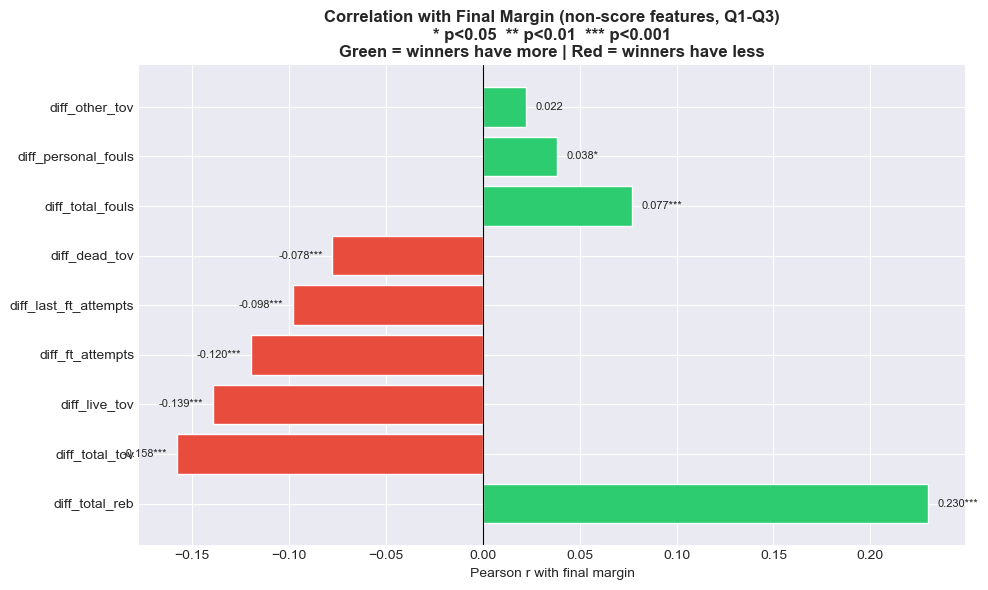


Model                                        R²      ±      ΔR²  n
--------------------------------------------------------------------
Baseline: cum_diff_Q3 only               0.516  0.034        —  3,463
+ Rebounds (total)                       0.516  0.033  -0.0000  3,463
+ Fouls (total + personal)               0.515  0.034  -0.0010  3,463
+ FT attempts + pct                      0.516  0.032  -0.0004  3,459
+ Turnover type (live/dead)              0.515  0.033  -0.0011  3,463
+ All combined                           0.514  0.031  -0.0021  3,459


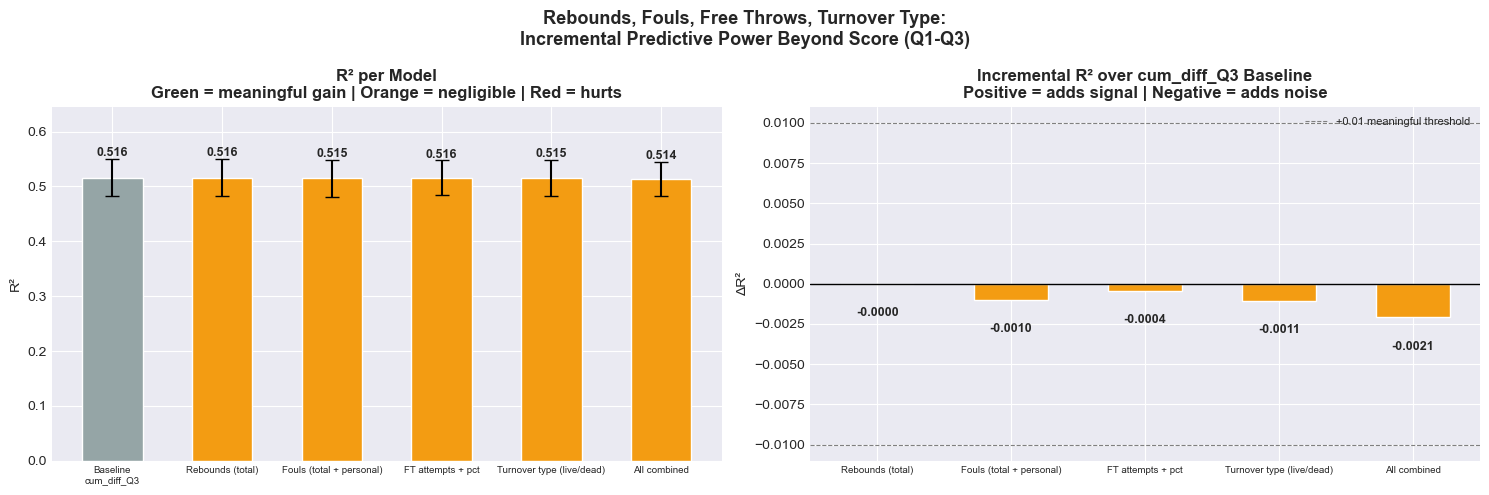

In [16]:
# ============================================================
# NON-SCORE FEATURES:
#     Rebound (total_reb): possession control via missed-shot recovery; may reflect advantage not fully captured by score.
#     Fouls (total_fouls, personal_fouls): accumulated fouls may constrain Q4 strategy (foul trouble, defensive adjustments).
#     Free throws (ft_attempts, ft_pct, last_ft_pct): aggression and shooting skill; attempts may show negative signal due to late intentional fouling.
#     Turnovers (total_tov, live_tov, dead_tov, other_tov): live-ball turnovers expected most predictive due to transition/fast-break impact.# ============================================================

q1_q3 = df[(df['period'].between(1, 3)) & (df['teamId'] != 0)].copy()

def extract_features_fixed(q1_q3):
    results = []

    for (gid, tid), grp in q1_q3.groupby(['gameId', 'teamId']):

        # --- Rebounds ---
        # No off/def split available in subType — use total only
        total_reb = (grp['actionType'] == 'Rebound').sum()

        # --- Fouls ---
        foul_mask      = grp['actionType'].str.contains('Foul', na=False)
        total_fouls    = foul_mask.sum()
        personal_fouls = (
            grp[foul_mask]['subType']
            .str.lower()
            .str.contains('personal', na=False)
            .sum()
        )

        # --- Free throws ---
        # ft_made uses shotResult directly (not subType string parsing)
        ft_mask      = grp['actionType'] == 'Free Throw'
        ft_grp       = grp[ft_mask]
        ft_attempts  = len(ft_grp)
        ft_made      = (ft_grp['shotResult'] == 'Made').sum()
        ft_pct       = ft_made / ft_attempts if ft_attempts > 0 else np.nan

        # Last FT of each trip to the line: "1 of 1", "2 of 2", "3 of 3"
        # A miss here gives the opponent a live rebound — higher stakes
        ft_sub = ft_grp['subType'].fillna('')
        last_ft_mask     = ft_sub.str.contains(
            r'\b1 of 1\b|\b2 of 2\b|\b3 of 3\b', regex=True, na=False
        )
        last_ft_attempts = last_ft_mask.sum()
        last_ft_made     = ft_grp[last_ft_mask]['shotResult'].eq('Made').sum()
        last_ft_pct      = last_ft_made / last_ft_attempts if last_ft_attempts > 0 else np.nan

        # --- Turnovers by type ---
        tov_mask  = grp['actionType'] == 'Turnover'
        tov_grp   = grp[tov_mask]
        total_tov = len(tov_grp)

        tov_sub  = tov_grp['subType'].str.lower().fillna('')
        # Live-ball: steal or immediate possession change — fast break risk
        live_tov = tov_sub.str.contains(
            'bad pass|lost ball|stolen', na=False
        ).sum()
        # Dead-ball: play resets, no fast-break advantage for opponent
        dead_tov = tov_sub.str.contains(
            'out of bounds|violation|shot clock|offensive foul|lane violation',
            na=False
        ).sum()
        other_tov = total_tov - live_tov - dead_tov

        results.append({
            'gameId':           gid,
            'teamId':           tid,
            'total_reb':        total_reb,        # possession control proxy
            'total_fouls':      total_fouls,      # foul trouble accumulation
            'personal_fouls':   personal_fouls,   # most common foul type
            'ft_attempts':      ft_attempts,      # aggressiveness / foul drawing
            'ft_made':          ft_made,          # raw free throw points
            'ft_pct':           ft_pct,           # free throw shooting skill
            'last_ft_attempts': last_ft_attempts, # pressure FT opportunities
            'last_ft_pct':      last_ft_pct,      # pressure FT make rate
            'total_tov':        total_tov,        # all turnovers
            'live_tov':         live_tov,         # dangerous (fast-break) turnovers
            'dead_tov':         dead_tov,         # less damaging turnovers
            'other_tov':        other_tov,        # unclassified residual
        })

    return pd.DataFrame(results)

print("\nExtracting features (Q1-Q3 only)...")
feat_df = extract_features_fixed(q1_q3)
print(f"Feature rows: {len(feat_df):,}  (expected: {q1_q3['gameId'].nunique() * 2:,})")

print("\nNaN counts per feature:")
print(feat_df.isnull().sum())

print("\nSample (first 4 rows):")
print(feat_df.head(4).to_string())

print("\nTurnover subType breakdown (verify live/dead classification):")
tov_sub_counts = (
    df[(df['actionType'] == 'Turnover') & df['period'].between(1,3) & (df['teamId'] != 0)]
    ['subType'].value_counts()
)
print(tov_sub_counts.head(20))
classified = (
    tov_sub_counts.index.str.lower().str.contains('bad pass|lost ball|stolen') |
    tov_sub_counts.index.str.lower().str.contains('out of bounds|violation|shot clock|offensive foul')
)
print(f"\nClassified as live or dead: {tov_sub_counts[classified].sum():,}")
print(f"Unclassified (other_tov):   {tov_sub_counts[~classified].sum():,}")


# ============================================================
# MERGE INTO PAIRED GAME DATASET
# One row per game: winner features (_w) vs loser features (_l)
# Differential = winner value minus loser value for each feature
# ============================================================

shots = df[df['isFieldGoal'] == 1].copy()
shots['is_made']       = shots['shotResult'] == 'Made'
shots['points_scored'] = np.where(shots['is_made'], shots['shotValue'], 0)

ft_pts_df = df[df['actionType'] == 'Free Throw'].copy()
ft_pts_df['points_scored'] = np.where(ft_pts_df['shotResult'] == 'Made', 1, 0)

shot_pts = shots.groupby(['gameId','teamId','period'])['points_scored'].sum().reset_index()
ft_pts   = ft_pts_df.groupby(['gameId','teamId','period'])['points_scored'].sum().reset_index()

qtr = (shot_pts
       .merge(ft_pts, on=['gameId','teamId','period'], how='outer',
              suffixes=('_s','_ft'))
       .fillna(0))
qtr['total_pts'] = qtr['points_scored_s'] + qtr['points_scored_ft']
qtr = qtr[qtr['period'].between(1,4) & (qtr['teamId'] != 0)].copy()

pts_wide = (
    qtr.pivot_table(index=['gameId','teamId'], columns='period',
                    values='total_pts', aggfunc='sum')
    .rename(columns={1:'pts_Q1',2:'pts_Q2',3:'pts_Q3',4:'pts_Q4'})
    .reset_index()
)
pts_wide['total_pts'] = pts_wide[['pts_Q1','pts_Q2','pts_Q3','pts_Q4']].sum(axis=1)
winners = pts_wide.groupby('gameId')['total_pts'].idxmax()
pts_wide['won'] = 0
pts_wide.loc[winners, 'won'] = 1

game_level = pts_wide.merge(feat_df, on=['gameId','teamId'], how='left')

w = game_level[game_level['won']==1].add_suffix('_w').rename(columns={'gameId_w':'gameId'})
l = game_level[game_level['won']==0].add_suffix('_l').rename(columns={'gameId_l':'gameId'})
gd = w.merge(l, on='gameId')

gd['cum_diff_Q1']  = gd['pts_Q1_w'] - gd['pts_Q1_l']
gd['cum_diff_Q2']  = gd['cum_diff_Q1'] + (gd['pts_Q2_w'] - gd['pts_Q2_l'])
gd['cum_diff_Q3']  = gd['cum_diff_Q2'] + (gd['pts_Q3_w'] - gd['pts_Q3_l'])
gd['final_margin'] = gd['cum_diff_Q3'] + (gd['pts_Q4_w'] - gd['pts_Q4_l'])

feat_base = ['total_reb','total_fouls','personal_fouls',
             'ft_attempts','ft_made','ft_pct',
             'last_ft_attempts','last_ft_pct',
             'total_tov','live_tov','dead_tov','other_tov']

new_feat_diffs = []
for f in feat_base:
    col = f'diff_{f}'
    gd[col] = gd[f'{f}_w'] - gd[f'{f}_l']
    new_feat_diffs.append(col)

print(f"\nPaired dataset: {len(gd):,} games")
print(f"NaN check on differentials:")
print(gd[new_feat_diffs].isnull().sum())


# ============================================================
# CORRELATIONS WITH FINAL MARGIN
# Positive r = winners have MORE of this feature
# Negative r = winners have LESS (e.g. fewer turnovers)
# ============================================================

corr_results = []
for col in new_feat_diffs:
    clean = gd[[col, 'final_margin']].dropna()
    if len(clean) < 10:
        continue
    r, p = stats.pearsonr(clean[col], clean['final_margin'])
    corr_results.append({'feature': col, 'r': r, 'p': p, 'n': len(clean)})

corr_df = pd.DataFrame(corr_results).sort_values('r', key=abs, ascending=False)
print("\nCorrelation with final margin:")
print(corr_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in corr_df['r']]
ax.barh(corr_df['feature'], corr_df['r'], color=colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
for i, row in corr_df.reset_index(drop=True).iterrows():
    sig = '***' if row['p'] < 0.001 else '**' if row['p'] < 0.01 else '*' if row['p'] < 0.05 else ''
    offset = 0.005 if row['r'] >= 0 else -0.005
    ax.text(row['r'] + offset, i, f"{row['r']:.3f}{sig}",
            va='center', ha='left' if row['r'] >= 0 else 'right', fontsize=8)
ax.set_title('Correlation with Final Margin (non-score features, Q1-Q3)\n'
             '* p<0.05  ** p<0.01  *** p<0.001\n'
             'Green = winners have more | Red = winners have less',
             fontweight='bold')
ax.set_xlabel('Pearson r with final margin')
plt.tight_layout()
plt.show()


# ============================================================
# INCREMENTAL R² TEST
# Key question: does any feature group push R² above the
# cum_diff_Q3 baseline of 0.516?
#
# ΔR² > +0.01 → meaningful independent signal, worth including
# ΔR² ≈  0.00 → redundant with score, drop
# ΔR² < -0.01 → adds noise, actively hurts, drop
# ============================================================

def cv_r2(cols, df, target='final_margin', cv=5):
    clean = df[cols + [target]].dropna()
    X = StandardScaler().fit_transform(clean[cols].values)
    y = clean[target].values
    scores = cross_val_score(Ridge(), X, y, cv=cv, scoring='r2')
    return scores.mean(), scores.std(), len(clean)

r2_base, sd_base, n_base = cv_r2(['cum_diff_Q3'], gd)

groups = {
    'Rebounds (total)':          ['diff_total_reb'],
    'Fouls (total + personal)':  ['diff_total_fouls', 'diff_personal_fouls'],
    'FT attempts + pct':         ['diff_ft_attempts', 'diff_ft_pct', 'diff_last_ft_pct'],
    'Turnover type (live/dead)': ['diff_live_tov', 'diff_dead_tov', 'diff_other_tov'],
    'All combined':              [c for c in new_feat_diffs if 'ft_made' not in c],
}

print(f"\n{'Model':<40} {'R²':>6}  {'±':>5}  {'ΔR²':>7}  n")
print("-" * 68)
print(f"{'Baseline: cum_diff_Q3 only':<40} {r2_base:.3f}  {sd_base:.3f}  {'—':>7}  {n_base:,}")

group_results = []
for label, cols in groups.items():
    valid_cols = [c for c in cols if c in gd.columns]
    r2, sd, n = cv_r2(['cum_diff_Q3'] + valid_cols, gd)
    delta = r2 - r2_base
    print(f"{'+ ' + label:<40} {r2:.3f}  {sd:.3f}  {delta:+.4f}  {n:,}")
    group_results.append({'label': label, 'r2': r2, 'sd': sd, 'delta': delta})

# ── Plot ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

all_labels = ['Baseline\ncum_diff_Q3'] + [g['label'] for g in group_results]
all_r2     = [r2_base] + [g['r2'] for g in group_results]
all_sd     = [sd_base] + [g['sd'] for g in group_results]
all_colors = ['#95a5a6'] + [
    '#2ecc71' if g['delta'] > 0.005 else
    '#e74c3c' if g['delta'] < -0.005 else '#f39c12'
    for g in group_results
]

axes[0].bar(all_labels, all_r2, yerr=all_sd, color=all_colors,
            edgecolor='white', capsize=5, width=0.55)
axes[0].set_title('R² per Model\nGreen = meaningful gain | Orange = negligible | Red = hurts',
                  fontweight='bold')
axes[0].set_ylabel('R²')
axes[0].set_ylim(0, max(all_r2) * 1.25)
for i, (m, s) in enumerate(zip(all_r2, all_sd)):
    axes[0].text(i, m + s + 0.005, f'{m:.3f}', ha='center', fontsize=9, fontweight='bold')
axes[0].tick_params(axis='x', labelsize=7)

deltas = [g['delta'] for g in group_results]
axes[1].bar([g['label'] for g in group_results], deltas,
            color=['#2ecc71' if d > 0.005 else '#e74c3c' if d < -0.005 else '#f39c12'
                   for d in deltas],
            edgecolor='white', width=0.55)
axes[1].axhline(0,     color='black', linewidth=1)
axes[1].axhline( 0.01, color='gray', linewidth=0.8, linestyle='--', label='+0.01 meaningful threshold')
axes[1].axhline(-0.01, color='gray', linewidth=0.8, linestyle='--')
axes[1].set_title('Incremental R² over cum_diff_Q3 Baseline\n'
                  'Positive = adds signal | Negative = adds noise',
                  fontweight='bold')
axes[1].set_ylabel('ΔR²')
axes[1].legend(fontsize=8)
for i, d in enumerate(deltas):
    axes[1].text(i, d + 0.001 if d >= 0 else d - 0.002,
                 f'{d:+.4f}', ha='center', fontsize=9, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=7)

plt.suptitle('Rebounds, Fouls, Free Throws, Turnover Type:\nIncremental Predictive Power Beyond Score (Q1-Q3)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()